**Face Mask detection**

Importing the necessary Python libraries







In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

Getting the data


> For training the model, I used the dataset created by [Jessica Li](https://https://www.kaggle.com/jessicali9530), which contains 12 thousand images divided into Test, Train, and Validation sets.
You can dowload it from here [here](https://https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset) .



In [2]:
# Load train and test set
train_loc = "drive/MyDrive/Face Mask Dataset/Train"
test_loc = "drive/MyDrive/Face Mask Dataset/Test"
val_loc = "drive/MyDrive/Face Mask Dataset/Validation"

Reading a sample image and performing face detection


> Reading a random sample image from the internet and perform face detection using a pre-trained face detection model.


> I used the [ Haar cascade classifier](https://https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html), originally known as the Viola-Jones Face Detection Technique, which is one of the most popular object detection algorithms for detecting faces in images or real-time video.
You can dowload it from [here](https://https://github.com/opencv/opencv/tree/master/data/haarcascades).



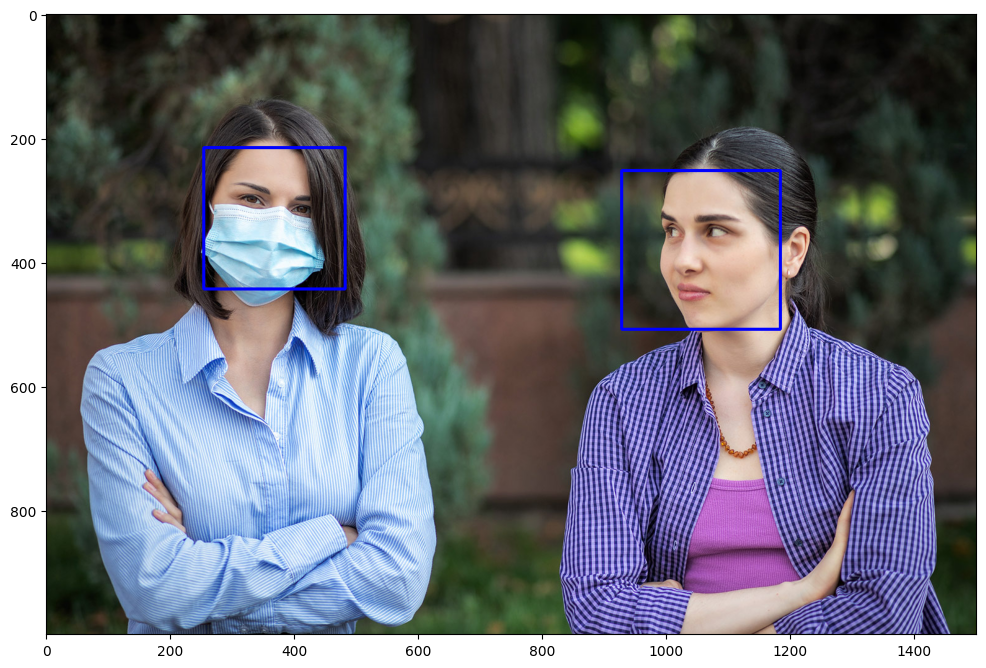

In [3]:
# Read a sample image
img = cv2.imread("drive/MyDrive/Face Mask Dataset/samples/sample5.jpg")

# Keep a copy of coloured image
original_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier("drive/MyDrive/Face Mask Dataset/haarcascade_frontalface_default.xml")

# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(img, scaleFactor=1.08, minNeighbors=4)  # returns a list of (x,y,w,h) tuples

# plotting the returned values
for (x, y, w, h) in return_faces: cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 0, 255), 3)

plt.figure(figsize=(12, 12))
plt.imshow(original_img)  # display the image

Data preprocessing 

In [4]:
datagenerator = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)

# Train data
train_set_gen = datagenerator.flow_from_directory(directory=train_loc, target_size=(128, 128), class_mode="categorical", batch_size=32)

# Validation data
val_set_gen = datagenerator.flow_from_directory(directory=val_loc, target_size=(128, 128), class_mode="categorical", batch_size=32)

# Test data
test_set_gen = datagenerator.flow_from_directory(directory=test_loc, target_size=(128, 128), class_mode="categorical", batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


Create the mask detection transfer learning model using Keras

> We are building the deep learning classifer using the VGG19 transfer learning model. The VGG19 model is the successor of AlexNet, a variation of the VGG model named after the group named as Visual Geometry Group at Oxford which created it. 

> It is a deep CNN consisting of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer), it's used to classify images. 





In [5]:
# Initializing the VGG19 model
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

# Compiling the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


Train the model

In [6]:
# Fit the model on train data along with validation data
model_history = model.fit_generator(
    generator=train_set_gen,
    steps_per_epoch = len(train_set_gen) // 32,
    epochs=20, #Training the model for 20 epoches
    validation_data = val_set_gen,
    validation_steps = len(val_set_gen) // 32,
)

<ipython-input-6-db2c743adfd2>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/20
9/9 [==============================] - 200s 22s/step - loss: 0.5251 - accuracy: 0.7396
Epoch 2/20
9/9 [==============================] - 178s 19s/step - loss: 0.2800 - accuracy: 0.9306
Epoch 3/20
9/9 [==============================] - 170s 18s/step - loss: 0.2044 - accuracy: 0.9444
Epoch 4/20
9/9 [==============================] - 161s 17s/step - loss: 0.1547 - accuracy: 0.9583
Epoch 5/20
9/9 [==============================] - 159s 17s/step - loss: 0.1454 - accuracy: 0.9688
Epoch 6/20
9/9 [==============================] - 156s 17s/step - loss: 0.1197 - accuracy: 0.9618
Epoch 7/20
9/9 [==============================] - 146s 15s/step - loss: 0.1148 - accuracy: 0.9722
Epoch 8/20
9/9 [==============================] - 141s 15s/step - loss: 0.0971 - accuracy: 0.9792
Epoch 9/20
9/9 [==============================] - 135s 15s/step - loss: 0.1219 - accuracy: 0.9583
Epoch 10/20
9/9 [==============================] - 135s 14s/step - loss: 0.0928 - accuracy: 0.9688
Epoch 11/20
9/9 [==

Evaluate the model performance on test set

In [7]:
model_loss, model_acc = model.evaluate(test_set_gen)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

31/31 [==============================] - 590s 19s/step - loss: 0.0925 - accuracy: 0.9647
Model has a loss of 0.09 and accuracy 96.47%


In [8]:
model.save('drive/MyDrive/Face Mask Dataset/Binary_model.h5')

Test the model on the sample image

1/1 [==============================] - 0s 374ms/step


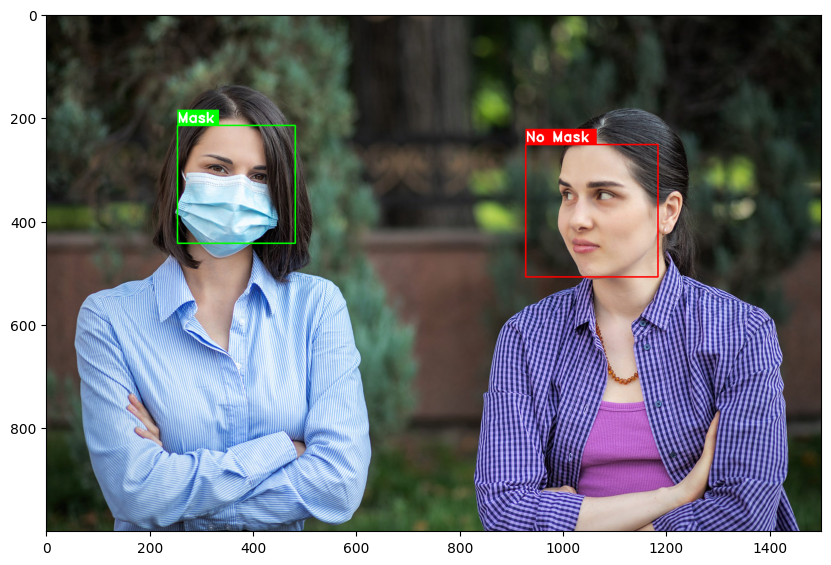

In [9]:
# label for mask detection
mask_det_label = {0: "Mask", 1: "No Mask"}
mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
pad_y = 1  # padding for result text

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# For detected faces in the image
for i in range(len(return_faces)):
    (x, y, w, h) = return_faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (128, 128))
    cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
    # make model prediction
    mask_result = model.predict(cropped_face) 
    # get mask/no mask based on prediction
    print_label = mask_det_label[mask_result.argmax()] 
    label_colour = mask_det_label_colour[mask_result.argmax()]

    # Print result
    (t_w, t_h), _ = cv2.getTextSize(print_label, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)
    
    # draw rectangle
    cv2.rectangle(
        main_img, (x, y + pad_y), (x + t_w, y - t_h - pad_y - 6), label_colour, -1,
        )
    
    # print text 
    cv2.putText(
        main_img, print_label, (x, y - 6), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2,
        )  
    
    # draw bounding box on face
    cv2.rectangle(
        main_img, (x, y), (x + w, y + h), label_colour, 1,
        )
    
    # draw bounding box on face
    cv2.rectangle(
        main_img, (x, y), (x + w, y + h), label_colour, thickness=2,
        )  
    
# display image
plt.figure(figsize=(10, 10))
plt.imshow(main_img) 